# Plot this paper's PCR parameter modification dataset

In [1]:
using Pkg
Pkg.activate("..")
using DataFrames, CSV, CairoMakie

  Activating project at `~/ben/chimera_detection/chimera_detection/notebooks`


In [2]:
# INPUTS
# collected CHMMAIRRa output from this paper's dataset
chimeric_path = "../../data/igdiscover22/PCR_conditions/collected/collected_CHMMAIRRa_out.tsv.gz"
# included with this paper's repository
PCR_conditions_path = "../data/PCR_conditions.tsv"

# OUTPUTS
plot_dir = "../../outputs/plots"

"../../data/igdiscover22/PCR_conditions/collected/collected_CHMMAIRRa_out.tsv.gz"

## Read in data, organize it and obtained percent chimerism


In [3]:
CHMMAIRRa_out = DataFrame(CSV.File(chimeric_path, delim = "\t"));
conditions = DataFrame(CSV.File(PCR_conditions_path, delim = "\t"));

chimeric = CHMMAIRRa_out[CHMMAIRRa_out.chimera_probability .> 0.95,:];

library_cts = combine(groupby(CHMMAIRRa_out, :case), :case => length => :library_reads);
# calculate number of chimeras
chimeric_summary = combine(groupby(chimeric, :case), nrow);
chimeric_summary[!,"condition"] = [split(case, "-")[2] for case in chimeric_summary.case];
# join on conditions
chimeric_summary = leftjoin(chimeric_summary, conditions, on  = [:condition => :Cond]);
# join on total library counts
chimeric_summary = leftjoin(chimeric_summary, library_cts, on = [:case => :case]);
chimeric_summary[!,"chimeric_percent"] = chimeric_summary[!,"nrow"] ./ chimeric_summary[!,"library_reads"] .* 100;
chimeric_summary[!,"donor"] .= [split(el, "-")[1] for el in chimeric_summary[!,"case"]];

## Plot

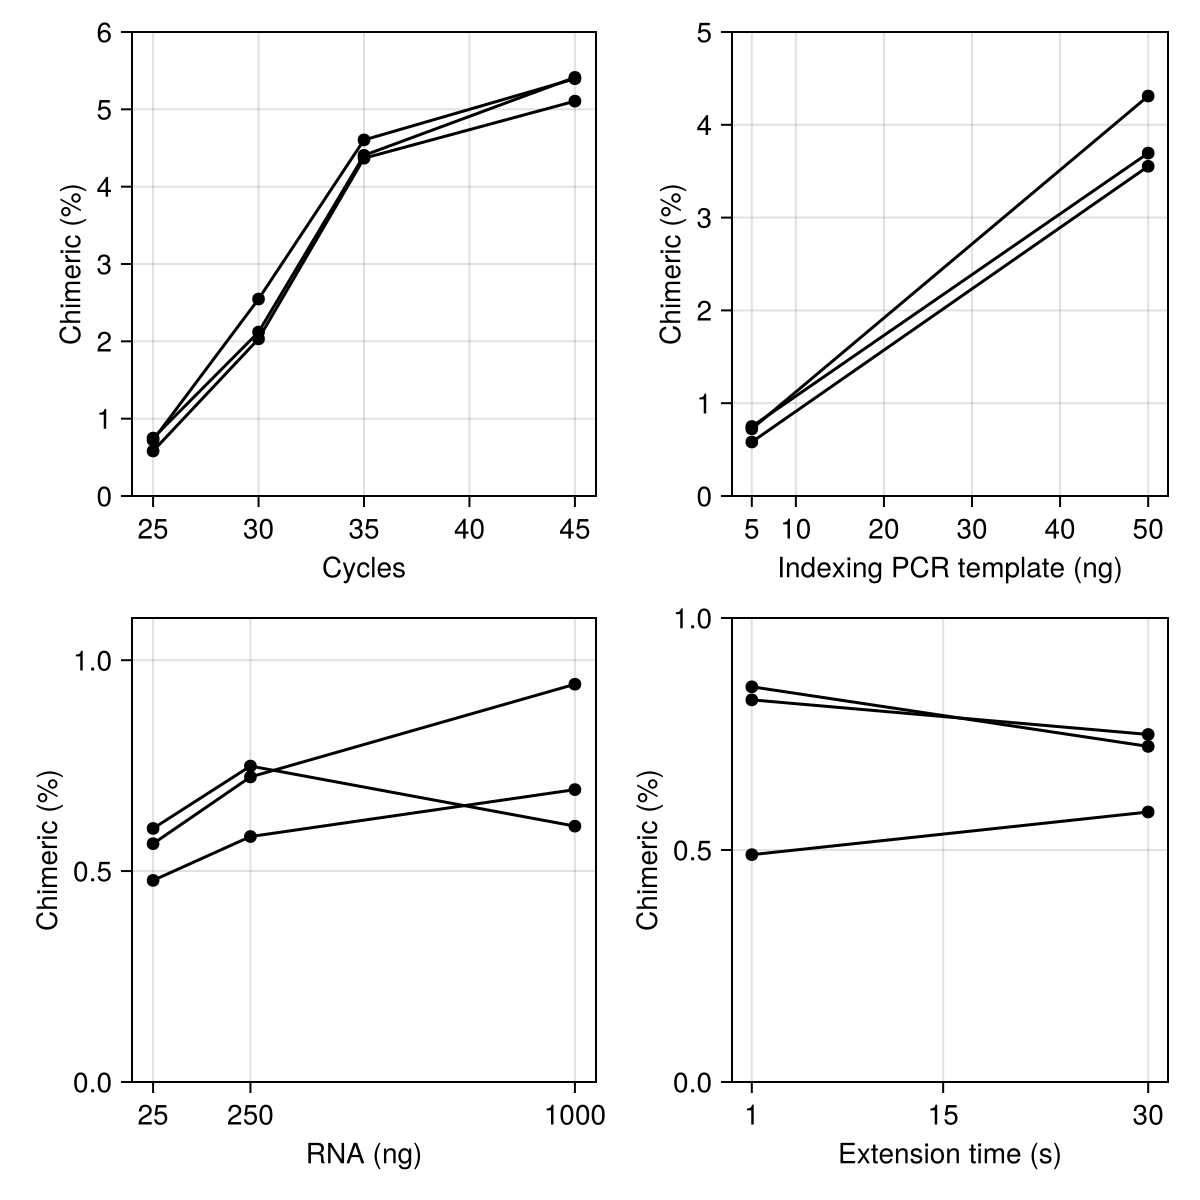

In [4]:
# plot the data
PCR_conditions_f = Figure(size = (600, 600))
cycles_a = Axis(PCR_conditions_f[1,1], ylabel = "Chimeric (%)", xlabel = "Cycles")
ind_template_a = Axis(PCR_conditions_f[1,2], ylabel = "Chimeric (%)", xlabel = "Indexing PCR template (ng)", xticks = [5,10,20,30,40,50])
RNA_a = Axis(PCR_conditions_f[2,1], ylabel = "Chimeric (%)", xlabel = "RNA (ng)", xticks = [25,250,1000])
time_a = Axis(PCR_conditions_f[2,2], ylabel = "Chimeric (%)", xlabel = "Extension time (s)", xticks = [1,15,30])

chimeric_summary = sort(chimeric_summary, [:donor, :condition])

subchimeric_summary = filter(row -> row.condition ∈ ["C1", "C2", "C3", "C4"], chimeric_summary)
CairoMakie.scatter!(cycles_a, subchimeric_summary.CYCLES, subchimeric_summary.chimeric_percent, color = :black)
for ((donor,), group) in pairs(groupby(subchimeric_summary, :donor))
    group_sorted = sort(group, :CYCLES)  # Sort by x-axis value
    CairoMakie.lines!(cycles_a, group_sorted.CYCLES, group_sorted.chimeric_percent, color = :black)
end
cycles_a.limits = (nothing, (0, 6))

subchimeric_summary = filter(row -> row.condition ∈ ["C8", "C1"], chimeric_summary)
CairoMakie.scatter!(ind_template_a, subchimeric_summary[!,"INDEXING(ng)"], subchimeric_summary.chimeric_percent, color = :black)
for ((donor,), group) in pairs(groupby(subchimeric_summary, :donor))
    CairoMakie.lines!(ind_template_a, group[!,"INDEXING(ng)"], group.chimeric_percent, color = :black)
end
ind_template_a.limits = (nothing, (0, 5))

subchimeric_summary = filter(row -> row.condition ∈ ["C5", "C1", "C6"], chimeric_summary)
CairoMakie.scatter!(RNA_a, subchimeric_summary[!,"RNA(ng)"], subchimeric_summary.chimeric_percent, color = :black)
for ((donor,), group) in pairs(groupby(subchimeric_summary, :donor))
    sort!(group, "RNA(ng)")
    CairoMakie.lines!(RNA_a, group[!,"RNA(ng)"], group.chimeric_percent, color = :black)
end
RNA_a.limits = (nothing, (0, 1.1))

subchimeric_summary = filter(row -> row.condition ∈ ["C7", "C1"], chimeric_summary)
CairoMakie.scatter!(time_a, subchimeric_summary[!,"EXT-TIME(seconds)"], subchimeric_summary.chimeric_percent, color = :black)
for ((donor,), group) in pairs(groupby(subchimeric_summary, :donor))
    CairoMakie.lines!(time_a, group[!,"EXT-TIME(seconds)"], group.chimeric_percent, color = :black)
end
time_a.limits = (nothing, (0, 1))

colsize!(PCR_conditions_f.layout, 1, Aspect(1, 1.0))
save(joinpath(plot_dir, "PCR_conditions.svg"), PCR_conditions_f)
PCR_conditions_f